In [1]:
import numpy as np 
import os
import numpy as np
from keras.models import *
from keras.layers import Input,Conv2D,MaxPooling2D,Dropout,UpSampling2D,concatenate
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler ,ReduceLROnPlateau,EarlyStopping
from keras import backend as keras
import skimage.io as io
import skimage.transform as trans
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import keras.backend as K

In [2]:
def mean_error(y_ture,y_pred):
    P=72
    error = K.abs(y_ture-y_pred)/P*255
    mean_error = K.mean(error)
    return mean_error

def accuracy_05(y_ture,y_pred):
    P=72
    within_05 = K.less_equal(K.abs(y_ture-y_pred)*255,P/2)
    accuracy = K.mean(within_05)
    return accuracy

def accuracy_1(y_ture,y_pred):
    P=72
    within_1 = K.less_equal(K.abs(y_ture-y_pred)*255,P)
    accuracy = K.mean(within_1)
    return accuracy

In [3]:
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = [mean_error,accuracy_05,accuracy_1])
    
    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [4]:
# 建立 UNet 模型
model=unet()
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# 輸出模型摘要
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

c:\Users\khant\anaconda3\envs\ai_nlp\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [5]:
train_folder  = 'ETT_v3/Fold3'

In [6]:
datagen = ImageDataGenerator(
    rescale = 1.0/255,
)
"""
    rotation_range=40,      # 隨機旋轉範圍
    width_shift_range=0.2,  # 水平隨機移動範圍
    height_shift_range=0.2, # 垂直隨機移動範圍
    shear_range=0.2,        # 剪切強度
    zoom_range=0.2,         # 隨機縮放範圍
    horizontal_flip=True,   # 隨機水平翻轉
    fill_mode='nearest'     # 填充像素的方法
)
"""
datagen_val = ImageDataGenerator(
    rescale = 1.0/255,
)

In [7]:
train_generator = datagen.flow_from_directory(
    train_folder,
    target_size=(256, 256),  # 指定目標尺寸
    batch_size=1,
    color_mode='grayscale',
    classes=['train'],
    class_mode=None ,   # 類別模式，圖形分割使用
    seed = 1
)

train_mask_generator = datagen.flow_from_directory(
    train_folder,
    target_size=(256, 256),  # 指定目標尺寸
    batch_size=1,
    color_mode='grayscale',
    classes=['trainannot'],
    class_mode=None ,   # 類別模式，圖形分割使用
    seed = 1
)

validation_generator = datagen_val.flow_from_directory(
    train_folder,
    target_size=(256, 256),  # 指定目標尺寸
    batch_size=1,
    color_mode='grayscale',
    classes=['val'],
    class_mode=None,      # 返回原始影像 根 標記內容
    seed = 1
)

val_mask_generator = datagen_val.flow_from_directory(
    train_folder,
    target_size=(256, 256),  # 指定目標尺寸
    batch_size=1,
    color_mode='grayscale',
    classes=['valannot'],
    class_mode=None,   # 類別模式，圖形分割使用
    seed = 1
)

train_combine = zip(train_generator,train_mask_generator)
val_combine = zip(validation_generator,val_mask_generator)



Found 287 images belonging to 1 classes.


Found 287 images belonging to 1 classes.
Found 47 images belonging to 1 classes.
Found 47 images belonging to 1 classes.


Shape of batch images: (1, 256, 256, 1)
Shape of batch images: (1, 256, 256, 1)


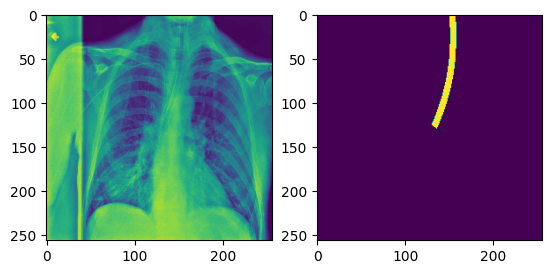

In [8]:
batch_images = next(train_generator)
batch_labels = next(train_mask_generator)
# 打印图像的形状
print("Shape of batch images:", batch_images.shape)
print("Shape of batch images:", batch_labels.shape)
# 显示图像的第一张图片
plt.subplot(1, 2, 1)  # 创建第一个子图像
plt.imshow(batch_images[0])
plt.subplot(1, 2, 2)  # 创建第二个子图像
plt.imshow(batch_labels[0])
plt.show()

In [9]:
early_stopping = EarlyStopping(monitor='val_loss',patience=20 ,restore_best_weights= True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5,min_lr=1e-6)
checkpoint = ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True,mode='min')

history = model.fit(
    train_combine,
    steps_per_epoch = len(train_generator),
    epochs=40,
    verbose=1,
    validation_data = val_combine,
    validation_steps = len(validation_generator),
    callbacks = [checkpoint]
)

Epoch 1/40
287/287 [==============================] - 37s 99ms/step - loss: 0.0390 - mean_error: 0.0684 - accuracy_05: 0.9700 - accuracy_1: 0.9839 - val_loss: 0.0243 - val_mean_error: 0.0521 - val_accuracy_05: 0.9766 - val_accuracy_1: 0.9916
Epoch 2/40
287/287 [==============================] - 29s 102ms/step - loss: 0.0263 - mean_error: 0.0536 - accuracy_05: 0.9705 - accuracy_1: 0.9841 - val_loss: 0.0257 - val_mean_error: 0.0618 - val_accuracy_05: 0.9643 - val_accuracy_1: 0.9890
Epoch 3/40
287/287 [==============================] - 30s 104ms/step - loss: 0.0229 - mean_error: 0.0481 - accuracy_05: 0.9742 - accuracy_1: 0.9834 - val_loss: 0.0262 - val_mean_error: 0.0512 - val_accuracy_05: 0.9732 - val_accuracy_1: 0.9846
Epoch 4/40
287/287 [==============================] - 31s 107ms/step - loss: 0.0232 - mean_error: 0.0468 - accuracy_05: 0.9756 - accuracy_1: 0.9829 - val_loss: 0.0222 - val_mean_error: 0.0405 - val_accuracy_05: 0.9834 - val_accuracy_1: 0.9903
Epoch 5/40
287/287 [=========

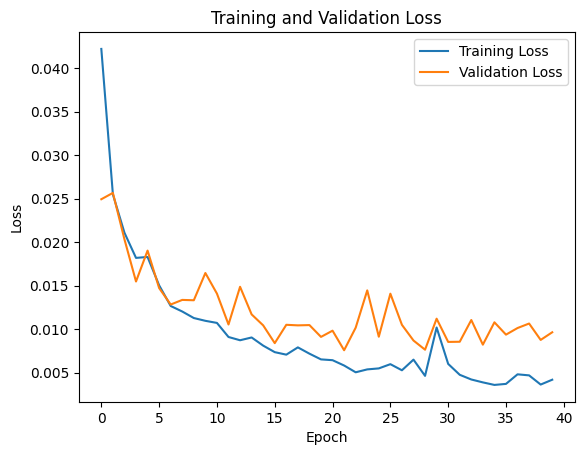

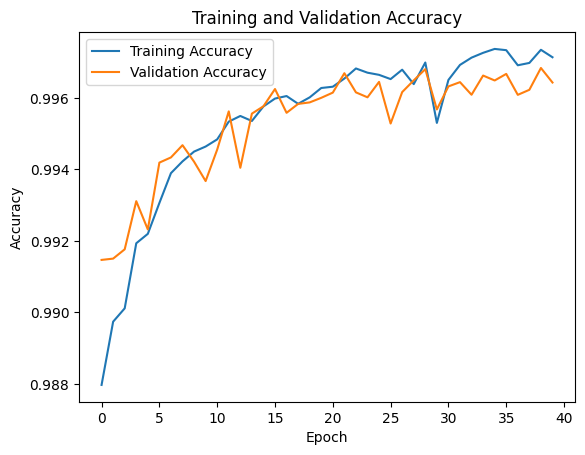

In [ ]:


# 繪製損失曲線
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('loss_plot.png')  # 將圖表保存為 PNG 文件
plt.show()

# 繪製準確度曲線
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig('accuracy_plot.png')  # 將圖表保存為 PNG 文件
plt.show()